In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
import utils

In [2]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
train_pairs, val_pairs, test_pairs = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of val pairs: {len(val_pairs)}")
print(f"Number of test_pairs pairs: {len(test_pairs)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [14]:
train_dataset = utils.create_dataset(train_pairs)
val_dataset = utils.create_dataset(val_pairs)
test_dataset = utils.create_dataset(test_pairs)

In [15]:
#batch the dataset and shuffle the training set
batch_size = 8

train_dataset = train_dataset.shuffle(buffer_size=len(train_pairs)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## Architecture definition

In [34]:
#define function for encoder convolutional layers
def convolutional_layer(input, num_filters, kernel_size=(3, 3)):
    #first convolution
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    #second convolution (common in U-Net encoders)
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [35]:
def basic_unet(input_size, num_filters=64):
    # Create the input tensor based on the input size
    inputs = tf.keras.Input(shape=input_size)

    # Encoder block
    first_conv = convolutional_layer(inputs, num_filters)
    first_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(first_conv)

    second_conv = convolutional_layer(first_layer, num_filters * 2)
    second_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(second_conv)

    third_conv = convolutional_layer(second_layer, num_filters * 4)
    third_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(third_conv)

    fourth_conv = convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)

    fifth_conv = convolutional_layer(fourth_layer, num_filters * 16)

    # Decoder block
    first_deconv = tf.keras.layers.Conv2DTranspose(num_filters * 8, kernel_size=(3, 3), strides=(2, 2), padding='same')(fifth_conv)
    sixth_layer = tf.keras.layers.concatenate([first_deconv, fourth_conv])
    sixth_conv = convolutional_layer(sixth_layer, num_filters * 8)

    second_deconv = tf.keras.layers.Conv2DTranspose(num_filters * 4, kernel_size=(3, 3), strides=(2, 2), padding='same')(sixth_layer)
    seventh_layer = tf.keras.layers.concatenate([second_deconv, third_conv])
    seventh_conv = convolutional_layer(seventh_layer, num_filters * 4)

    third_deconv = tf.keras.layers.Conv2DTranspose(num_filters * 2, kernel_size=(3, 3), strides=(2, 2), padding='same')(seventh_layer)
    eighth_layer = tf.keras.layers.concatenate([third_deconv, second_conv])
    eighth_conv = convolutional_layer(eighth_layer, num_filters * 2)

    fourth_deconv = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(eighth_conv)
    ninth_layer = tf.keras.layers.concatenate([fourth_deconv, first_conv])
    ninth_conv = convolutional_layer(ninth_layer, num_filters)

    #output layer
    output = tf.keras.layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(ninth_conv)

    unet = tf.keras.Model(inputs=inputs, outputs=output)

    return unet


In [38]:
basic_unet = basic_unet(input_size=(256, 256, 3))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
dice_coefficient = utils.dice_coefficient
iou = utils.iou

basic_unet.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", dice_coefficient, iou])

In [39]:
history = basic_unet.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
49/49 [==============================] - 28s 528ms/step - loss: 0.3459 - accuracy: 0.8841 - dice_coefficient: 0.1688 - iou: 0.0928 - val_loss: 31.8696 - val_accuracy: 0.5034 - val_dice_coefficient: 0.1372 - val_iou: 0.0746
Epoch 2/10
49/49 [==============================] - 27s 534ms/step - loss: 0.2590 - accuracy: 0.9091 - dice_coefficient: 0.2668 - iou: 0.1563 - val_loss: 0.4263 - val_accuracy: 0.8556 - val_dice_coefficient: 0.1745 - val_iou: 0.0972
Epoch 3/10
49/49 [==============================] - 28s 561ms/step - loss: 0.2308 - accuracy: 0.9175 - dice_coefficient: 0.3325 - iou: 0.2010 - val_loss: 0.6661 - val_accuracy: 0.7641 - val_dice_coefficient: 0.2255 - val_iou: 0.1289
Epoch 4/10
49/49 [==============================] - 33s 656ms/step - loss: 0.2183 - accuracy: 0.9217 - dice_coefficient: 0.3745 - iou: 0.2322 - val_loss: 0.3707 - val_accuracy: 0.8291 - val_dice_coefficient: 0.2405 - val_iou: 0.1397
Epoch 5/10
49/49 [==============================] - 35s 710ms/step 

In [22]:
test_loss, test_accuracy = basic_unet.evaluate(test_dataset)

17/17 [==============================] - 4s 212ms/step - loss: 0.2582 - accuracy: 0.8999


1/1 [==============================] - 0s 47ms/step


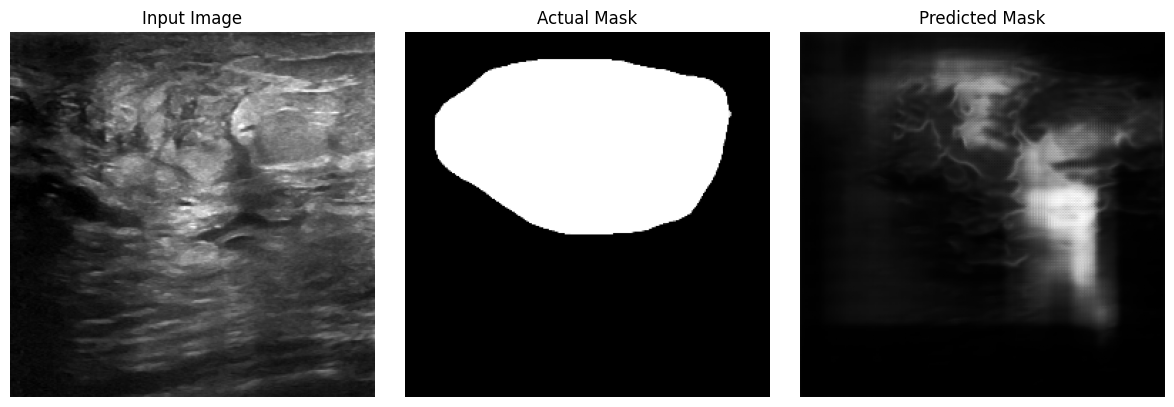

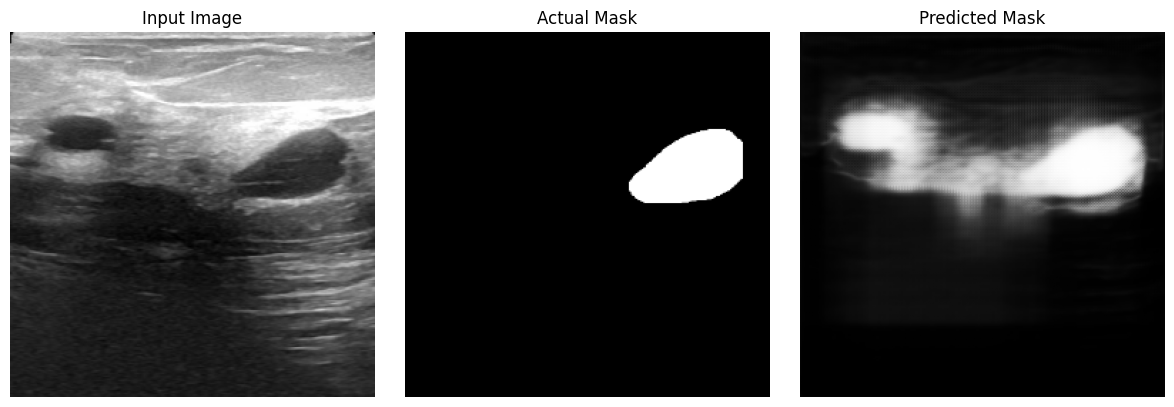

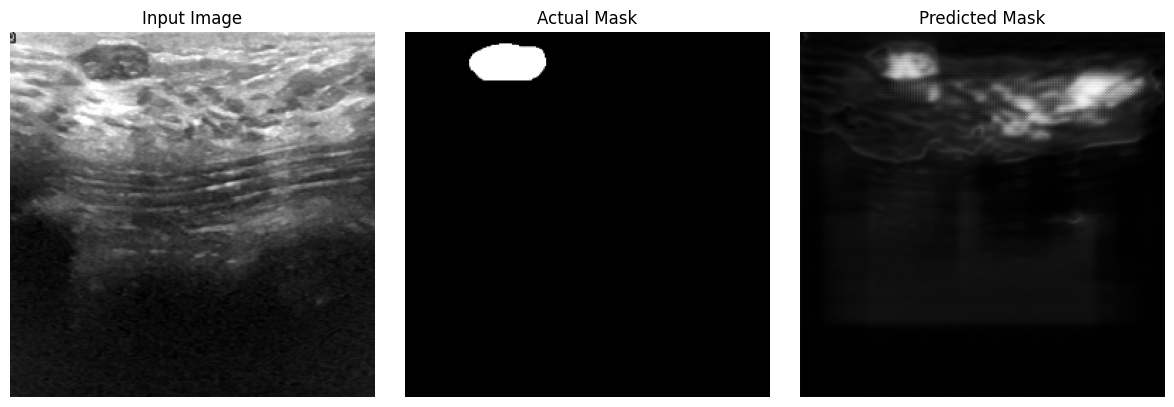

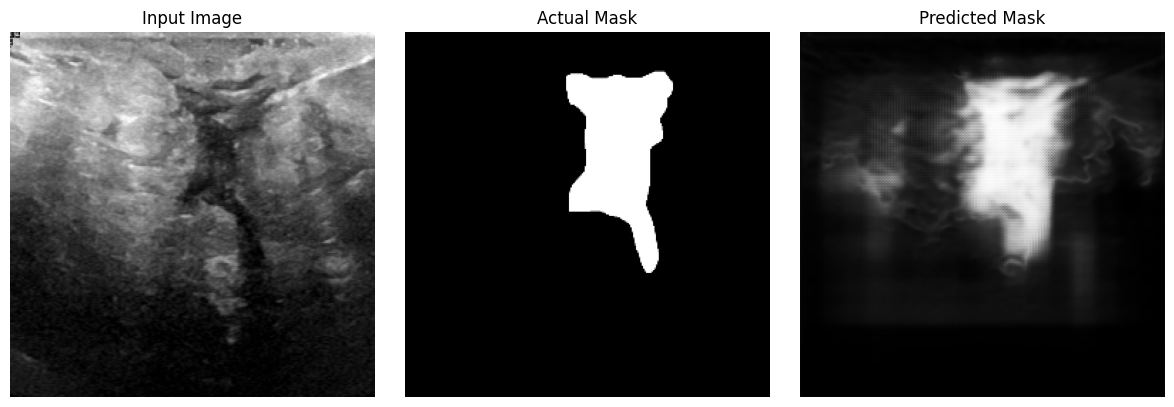

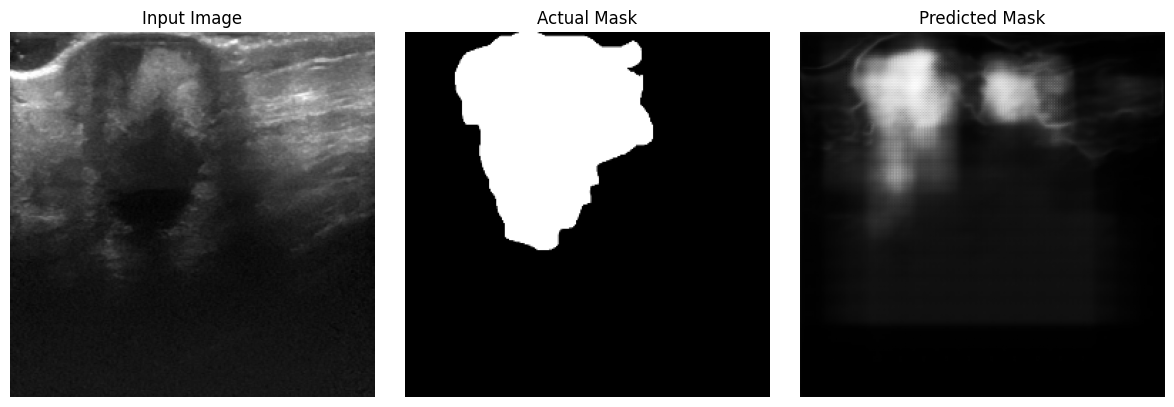

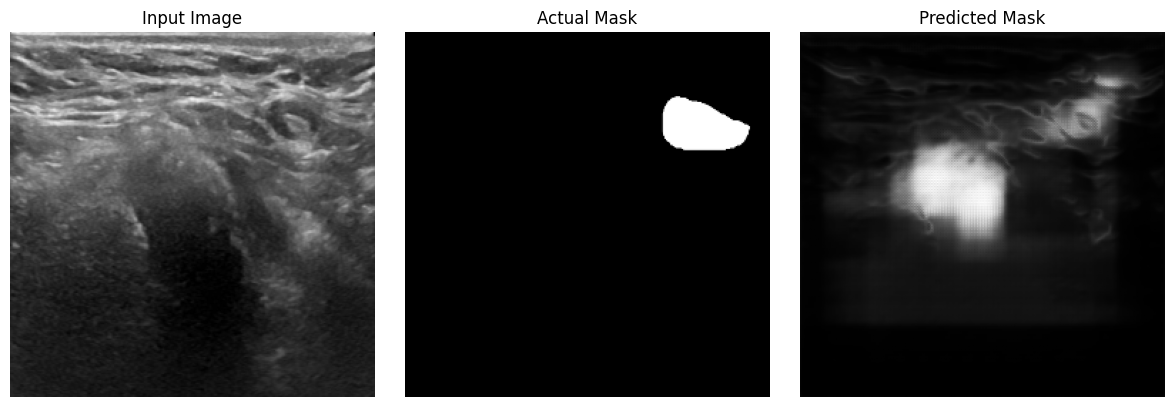

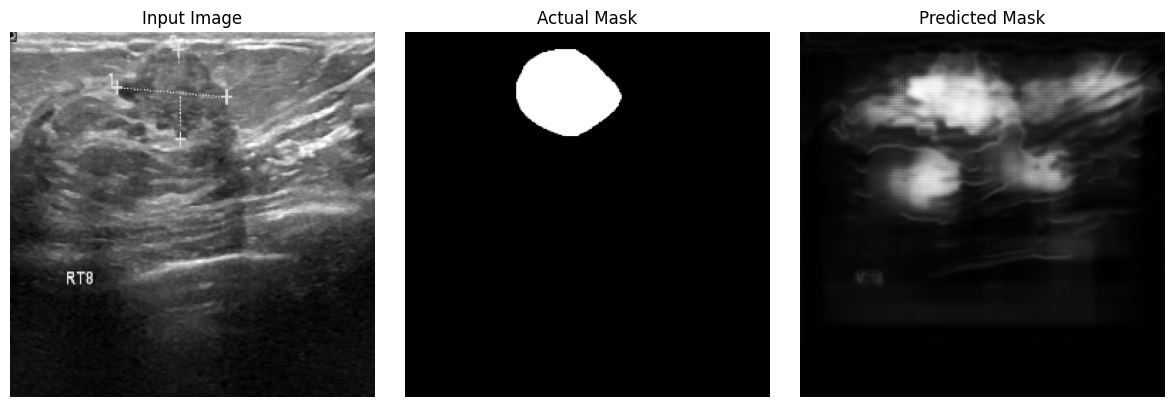

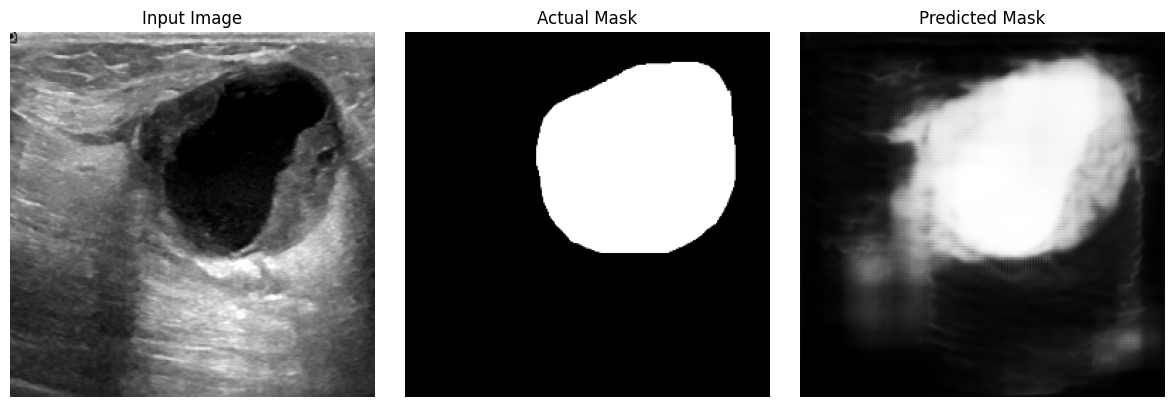

In [28]:
for i, (image, mask) in enumerate(test_dataset.take(1)):
    predicted_mask = basic_unet.predict(image)
    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()